# Решение задачи регрессии с помощью нейронной сети

Цель задачи регрессии состоит в том, чтобы предсказать вещественное значение, такое как физическое значение, финансовый результат или вероятность какого-либо события. Альтернативной задачей в обучении с учителем является задача классификации , ставящая цель предсказать для новых данных класс из списка классов (поставить диагноз по результатам обследования, определить объект на изображении и т.п.).

В этом блокноте используется классический набор данных [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)  и демонстрируется создание моделей, решающих задачу прогнозирования топливной эффективности автомобилей. Структура базы данных такие атрибуты, как количество цилиндров, рабочий объем, мощность, вес, динамика разгона и т.п.

Примеры реализованы с использованием API Keras. При необходимости получить дополнительные сведения о нем можно обратиться к [учебным примерам](https://www.tensorflow.org/tutorials/keras) и [руководствам](https://www.tensorflow.org/guide/keras) to learn more.)

In [ ]:
# Графики строятся при помощи seaborn.
!pip install -q seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

# Используем инструменты NumPy для улучшения читаемости
np.set_printoptions(precision=3, suppress=True)
encoder = OrdinalEncoder()

In [2]:
# Импорт библиотек
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


## Датасет топливной эффективности автомобилей.
Данные датасета представляют собой технические характеристиками автомобилей. Набор данных загружается из репозитория машинного обучения UCI.
Набор данных был взят из библиотеки StatLib, которая поддерживается в Университете Карнеги-Меллона. Набор данных
использовался в экспозиции Американской статистической ассоциации 1983 года.
В соответствии с использованием Россом Куинланом (1993) при прогнозировании атрибута «миль на галлон» 8 исходных экземпляров были удалены, поскольку они имели неизвестные значения атрибута «миль на галлон». 
Данные описывают расход топлива в городском цикле в милях на галлон, который должен быть предсказан с точки зрения 3 многозначных дискретных и 5 непрерывных атрибутов.
 - Количество экземпляров: 398
 - Количество атрибутов: 9, включая атрибут класса

Информация об атрибутах:

- миль на галлон: непрерывный
- цилиндры: многозначные дискретные
- вместимость: непрерывное
- мощность: непрерывная
- вес: непрерывный
- ускорение: непрерывное
- год выпуска: многозначный дискретный
- происхождение: многозначный дискретный
- имя автомобиля: строка (уникальная для каждого экземпляра)

Отсутствующие значения атрибута: лошадиные силы имеют 6 отсутствующих значений.
Датасет доступен по ссылке: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Загрузка данных
Данные загружаются из репозитория с использованием средств TensorFlow

In [6]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       ("http://archive.ics.uci.edu/ml/machine-learning-databases"
                                        "/auto-mpg/auto-mpg.data"))

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'ModelYear', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

raw_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Выполним копирование базы данных в рабочую копию, убедимся, что все в порядке со структурой

In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
print(dataset.dtypes)

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
ModelYear         int64
Origin            int64
dtype: object


### Очистка данных
Датасет содержит несколько строк с пустыми значениями.

In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

Удалим их, чтобы не вызывать сбоев в работе нейронной сети.

In [10]:
dataset = dataset.dropna()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Столбец `"Origin"` (страна происхождения) является категориальным, а не числовым. Соответственно, следующим шагом является однократное кодирование значений (one-hot-encoding) в столбце с помощью [pd.get_dummies] (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html ).

Примечание: Вы можете настроить `tf.keras.Модель` для выполнения такого рода преобразований за вас, но это выходит за рамки данного руководства. Студенты, заинтересованные глубже разобраться с темой могут сделать это с помощью руководств [Классифицировать структурированные данные с использованием слоев предварительной обработки Keras](../structured_data/preprocessing_layers.ipynb) или [Загрузить данные CSV](../load_data/csv.ipynb) для получения примеров.
На первом этапе выполним перекодировку страны происхождения в номер класса:

In [11]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


И затем выполним однократное кодирование столбца `"Origin"` при помощи get_dummies()

In [12]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Разделение данных на обучающие и тестовые наборы

Выполним разделиение набора данных на обучающий набор и тестовый набор. Вы будете использовать тестовый набор при окончательной оценке ваших моделей.

In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Проверка данных

Просмотрим совместное распределение нескольких пар столбцов из обучающего набора.

Верхний ряд указывает на то, что топливная экономичность (миль на галлон) зависит от всех остальных параметров. Другие строки указывают на то, что они являются функциями друг друга.

In [14]:
train_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Europe,Japan,USA
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0
182,28.0,4,107.0,86.0,2464.0,15.5,76,1,0,0


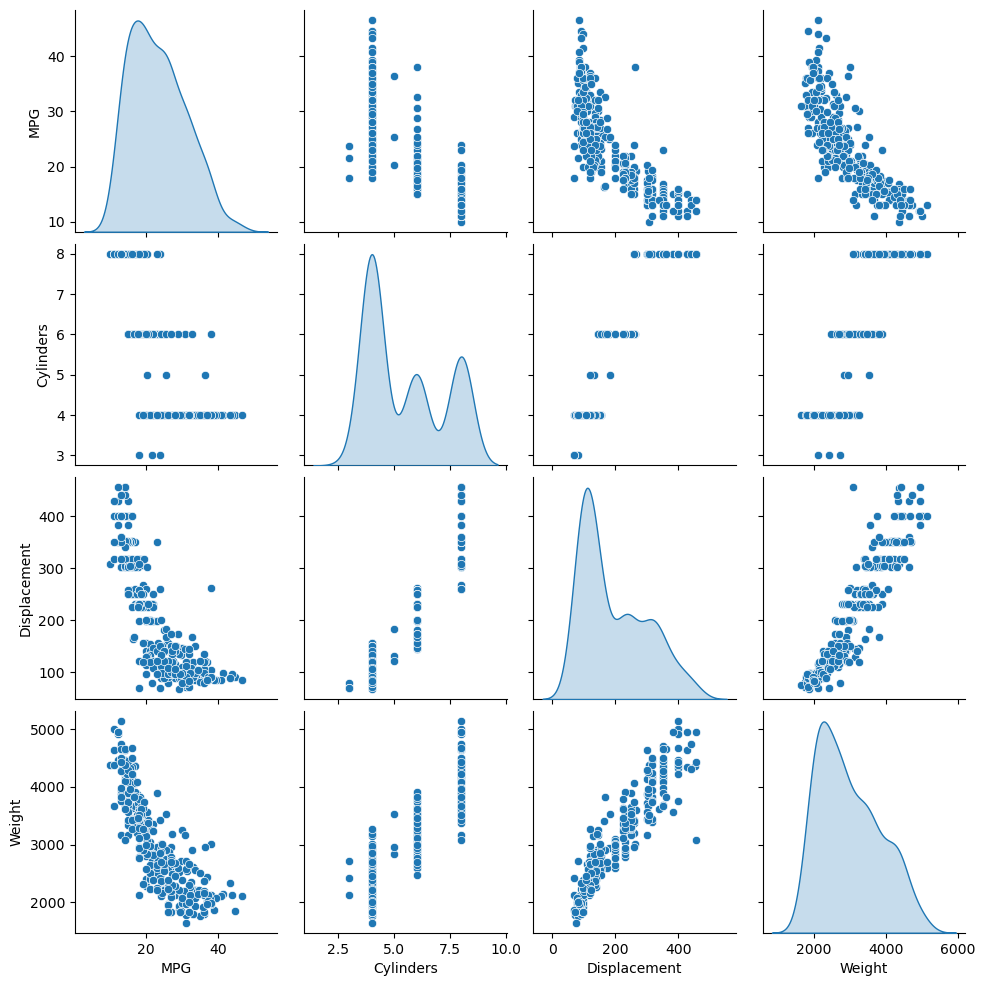

In [15]:
train_dataset['MPG'] = train_dataset['MPG'].fillna(pd.NA)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]].astype(float), diag_kind='kde')

Давайте также проверим общую статистику. Обратите внимание, что каждое свойство охватывает совершенно разный диапазон значений:

In [16]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
ModelYear,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Отделение объектов от меток

Отделим целевое значение ("метку") от значений данных. Эта метка - значение, для прогнозирования которого мы будем обучать модель.

In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Нормализация данных

В таблице статистики легко увидеть, насколько различаются диапазоны каждой функции:

In [18]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
ModelYear,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


Хорошей практикой является нормализация объектов, использующих разные масштабы и диапазоны.

Одна из причин, по которой это важно, заключается в том, что характеристики умножаются на вес модели. Таким образом, масштаб выходных данных и масштаб градиентов зависит от масштаба входных данных.

Хотя модель *может* сходиться без нормализации характеристик, нормализация делает обучение намного более стабильным.

**Примечание:** В нормализации одноразовых функций нет никаких преимуществ — это сделано здесь для простоты. Для получения более подробной информации о том, как использовать слои предварительной обработки, обратитесь к [Работа со слоями предварительной обработки].(https://www.tensorflow.org/guide/keras/preprocessing_layers ) руководство и руководство по [Классификации структурированных данных с использованием слоев предварительной обработки Keras](../structured_data/preprocessing_layers.ipynb).

### Слой нормализации

`tf.keras.layers.Normalization` - это простой и прозрачный способ добавить нормализацию параметров в вашу модель.

Первым шагом является создание слоя: (../structured_data/preprocessing_layers.ipynb).

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Затем производится предобучение нормализатора, его сопоставление с данными путем вызова `Normalization.adapt`:

In [20]:
normalizer.adapt(np.array(train_features))

Значение матожидания и дисперсии вычисляется и сохранятся в слое:

In [21]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


Теперь при вызове слоя он возвращает нормализованные входные данные, причем каждый объект (свойство) нормализуется независимо:

In [22]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Линейная регрессия

Прежде чем строить модель глубокой нейронной сети начнем с линейной регрессии с использованием одной или нескольких переменных.

### Одномерная линейная регрессия

Начнем с одномерной линейной регрессии, попытавшись предсказать `МИЛЬ на галлон"` (расход топлива) по `лошадиным силам` (мощности автомобиля).

Обучение модели с помощью `tf.keras` обычно начинается с определения архитектуры модели. Используйте `tf.keras.Последовательная" модель, которая [представляет собой последовательность шагов](https://www.tensorflow.org/guide/keras/sequential_model ).

В вашей модели линейной регрессии с одной переменной есть два этапа:

- Нормализация входных параметров `Лошадиной силы"`, используя слой предварительной обработки `tf.keras.layers.Normalization`.
- Применение линейного преобразования ($y = mx+b$) для получения 1 вывода с использованием линейного слоя (на основе полносвязного слоя `tf.keras.layers.Dense`).

Количество _inputs_ может быть задано либо с помощью аргумента `input_shape`, либо автоматически при первом запуске модели.

Сначала создадим массив NumPy, состоящий из элементов атрибута `Лошадиные силы`. Затем создадим экземпляр `tf.keras.layers.Normalization` и обучим его в соответствие с данными `лошадиные силы`:

In [23]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Построим слоистую (Sequential) модель Keras:

In [24]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Модель предсказывает значение `'MPG'` на основании `'Horsepower'`.

Запустим необученную модель на первых 10 значениях `"Horsepower"`. Результат не будет хорошим, но обратите внимание, что он имеет ожидаемую форму `(10, 1)`:

In [25]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 79ms/step


array([[ 0.419],
       [ 0.236],
       [-0.773],
       [ 0.587],
       [ 0.531],
       [ 0.208],
       [ 0.629],
       [ 0.531],
       [ 0.138],
       [ 0.236]], dtype=float32)

Когда модель построена, процедуру ее обучения необходимо настроить с помощью метода Keras `Model.compile`. Наиболее важными аргументами для компиляции являются `loss` и `optimizer`, поскольку они определяют, что будет оптимизировано (`mean_absolute_error`) и как (с использованием `tf.keras.optimizers.Adam`).


In [26]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Используем функцию Keras `Model.fit` чтобы выполнить обучение модели в течении 100 эпох:

In [27]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Отключаем отчеты по процессу.
    verbose=0,
    # Используем 20% обучающих данных для валидации.
    validation_split = 0.2)

CPU times: total: 1.81 s
Wall time: 3.37 s


Визуализируем прогресс обучения модели с использованием статистики, хранящейся в объекте `history`:

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802663,4.193916,95
96,3.802042,4.202326,96
97,3.803884,4.189929,97
98,3.808801,4.171210,98
99,3.806175,4.191746,99


In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Ошибка обучения')
  plt.plot(history.history['val_loss'], label='Ошибка валидации')
  plt.ylim([0, 10])
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка прогноза по [MPG]')
  plt.legend()
  plt.grid(True)

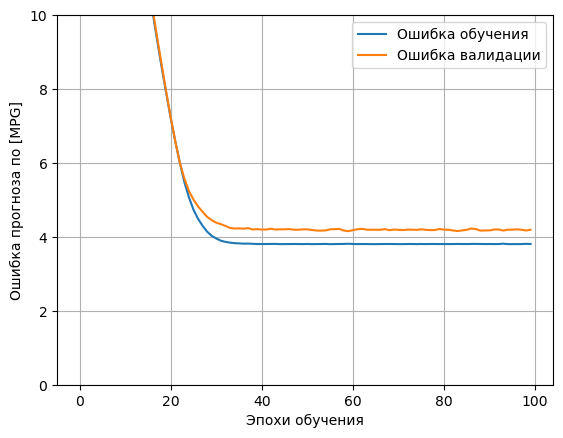

In [32]:
plot_loss(history)

Соберём результаты в тестовом наборе для последующего использования:

In [33]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Поскольку это одномерная регрессия, легко просмотреть прогнозы модели в зависимости от входных данных:

In [34]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


In [35]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Истинные значения')
  plt.plot(x, y, color='k', label='Прогнозы')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

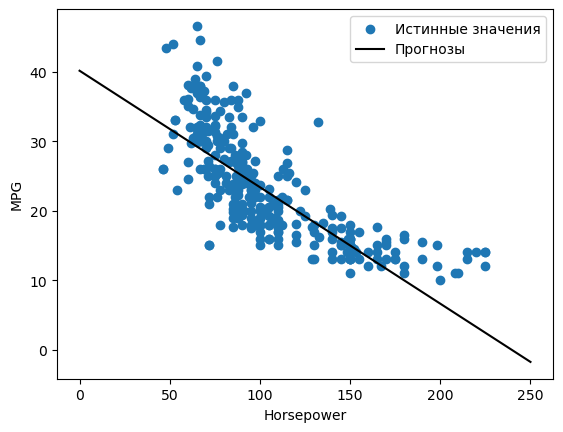

In [36]:
plot_horsepower(x, y)

### Многомерная линейная регрессия

Мы можем использовать почти идентичную модель для формирования прогнозов для многомерных входных данных. Эта модель по-прежнему выполняет то же самое $y = mx + b$, за исключением того, что $ m$ - это матрица, а $ b$ - вектор.

Снова создадим двухслойную последовательную модель Keras с первым слоем `normalizer` (`tf.keras.слои.Нормализация(ось=-1)`), которую вы определили ранее и обучили на всем наборе данных:

In [37]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

Когда мы вызываем `Model.predict` для пакета входных данных, он выдает выходные данные `units=1` для каждого примера:

In [38]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 49ms/step


array([[ 0.521],
       [-0.889],
       [-0.41 ],
       [-0.311],
       [-0.315],
       [-0.604],
       [-0.296],
       [ 0.077],
       [-0.096],
       [ 0.044]], dtype=float32)

Когда мы вызываем модель, это приводит к формированию матрицы весов этой модели, в частности матрица синаптических весов "ядра" ($ m$ в $y = mx +b $) имеет форму `(9, 1)`:

In [39]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.077],
       [ 0.192],
       [-0.616],
       [-0.227],
       [-0.444],
       [-0.469],
       [ 0.348],
       [-0.117],
       [-0.313]], dtype=float32)>

Сконфигурируем модель с помошью функции Keras `Model.compile` и обучим ее за 100 эпох с помощью `Model.fit`, используя среднеквадратическую функцию ошибки:

In [41]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [42]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Подавляем вывол протоколов обучения.
    verbose=0,
    # Используем 20% обучающих данных для валидации.
    validation_split = 0.2)

CPU times: total: 1.66 s
Wall time: 3.31 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

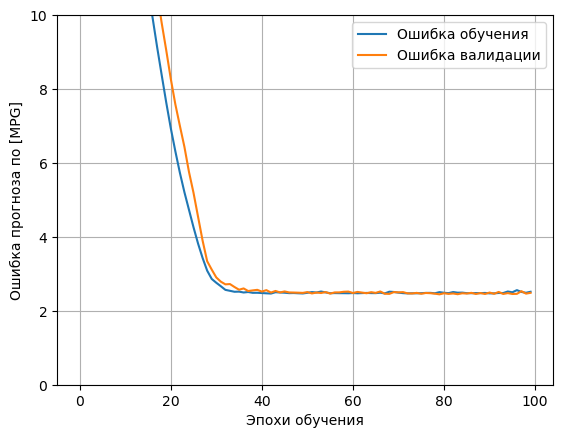

In [43]:
plot_loss(history)

Соберём результаты в тестовом наборе для последующего использования:

In [44]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Решение задачаи одномерной регрессии с помощью многослойной нейросети (DNN)

В предыдущем разделе мы реализовали две линейные модели для одного и нескольких входов.

Здесь мы будем реализовывать модели DNN с одним входом и несколькими входами.

Код в основном тот же, за исключением того, что модель расширена и включает в себя некоторые "скрытые" нелинейные слои. Название "скрытый" здесь просто означает, что он не подключен напрямую к входам или выходам.

Эти модели будут содержать на несколько слоев больше, чем линейная модель:

* Слой нормализации, как и раньше (с `horsepower_normalizer` для модели с одним входом и `normalizer` для модели с несколькими входами).
* Два скрытых, нелинейных, `плотных` (полносвязанных) слоя с нелинейной функцией активации ReLU (`релю`).
* Линейный `плотный` слой с одним выходом.

Обе модели будут использовать одну и ту же процедуру обучения, поэтому метод `compile` включен в приведенную ниже функцию `build_and_compile_model`..

In [45]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [47]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

Эта модель имеет гораздо больше обучаемых параметров, чем линейные модели:

In [48]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Обучим модель с помошью функции Keras `Model.fit`:

In [49]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 2 s
Wall time: 3.61 s


Эта модель работает немного лучше, чем одномерная линейная регрессия `horsepower_model`:

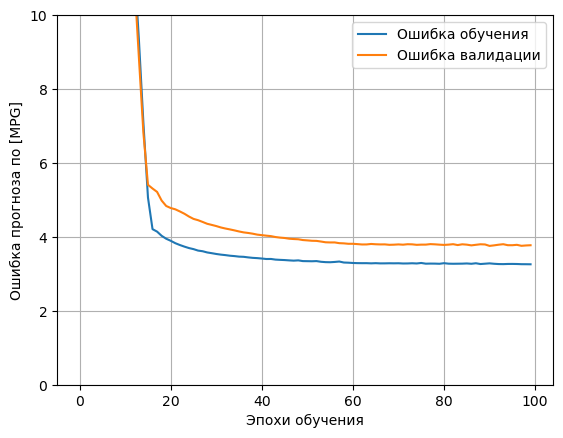

In [50]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:
Если мы построим график предсказаний в зависимости от `'Horsepower'`, то должны заметить, как эта модель использует преимущества нелинейности, обеспечиваемой скрытыми слоями:

In [51]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 938us/step


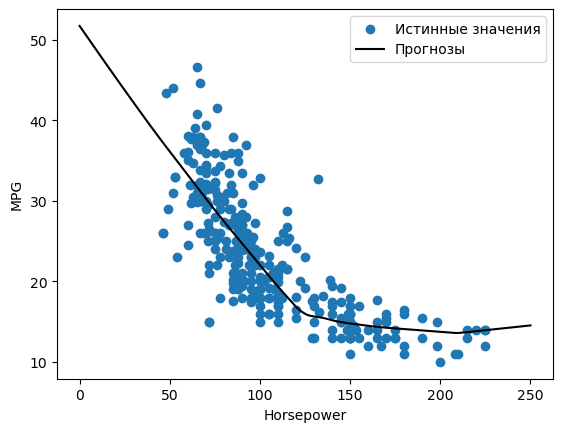

In [52]:
plot_horsepower(x, y)

Как и ранее, соберем результаты в тестовом наборе для последующего использования:

In [53]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Решение задачаи многомерной регрессии с помощью многослойной нейросети (DNN)

Повторим предыдущий процесс, используя все входные данные. Тосность модели немного улучшается при использовании набора проверочных данных.

In [54]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [55]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 2.19 s
Wall time: 3.74 s


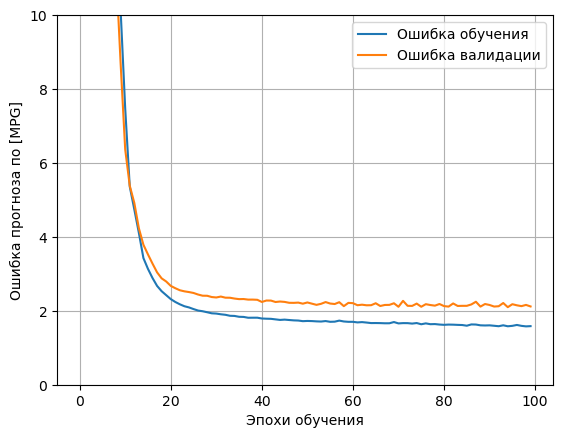

In [56]:
plot_loss(history)

Collect the results on the test set:

In [57]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Качество модели

Since all models have been trained, we can review their test set performance:

In [58]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648137
linear_model,2.496514
dnn_horsepower_model,2.931977
dnn_model,1.822031


Эти результаты соответствуют ошибке проверки, наблюдаемой во время обучения.

### Выполнение прогноза

Теперь мы можем делать прогнозы с помощью `dnn_model` в тестовом наборе, используя Keras `Model.predict` и анализировать ошибку прогнозирования:

3/3 [==============================] - 0s 1ms/step


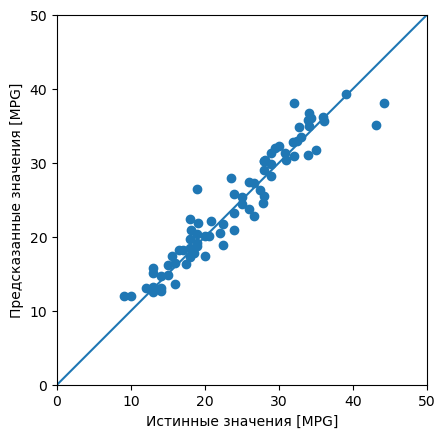

In [59]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('Истинные значения [MPG]')
plt.ylabel('Предсказанные значения [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Можно видеть, что модель предсказывает целевое значение достаточно неплохо.

Теперь проверим распределение ошибок:

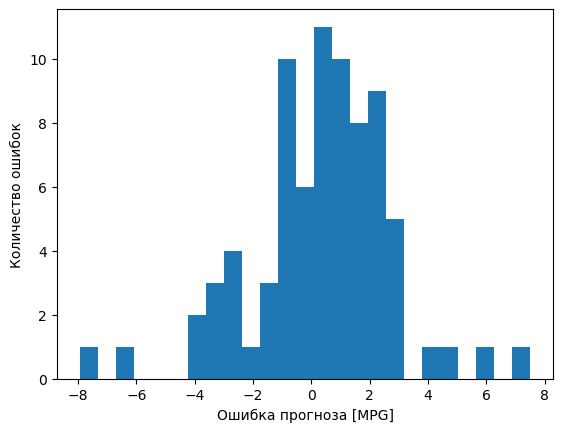

In [61]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Ошибка прогноза [MPG]')
_ = plt.ylabel('Количество ошибок')

Если модель вас устраивает, сохраните ее для последующего использования с Model.save:

In [63]:
dnn_model.save('D:\\Anaconda\\models\\')

INFO:tensorflow:Assets written to: D:\Anaconda\models\assets


INFO:tensorflow:Assets written to: D:\Anaconda\models\assets


Если мы перезагрузим модель, она выдаст идентичный результат:

In [64]:
reloaded = tf.keras.models.load_model('D:\\Anaconda\\models\\')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [65]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648137
linear_model,2.496514
dnn_horsepower_model,2.931977
dnn_model,1.822031
reloaded,1.822031


## Вывод

В этом разделе представлено несколько методов решения проблемы регрессии инструментами TensorFlow. Вот еще несколько полезных советов:

- Среднеквадратичная ошибка (MSE) (`tf.keras.потери.Среднеквадратичная ошибка`) и средняя абсолютная ошибка (MAE) (`tf.keras.потери.MeanAbsoluteError`) - это распространенные функции ошибки, используемые для задач регрессии. MAE менее чувствительна к выбросам. Для задач классификации используются различные функции ошибки.
- Аналогичным образом, оценочные показатели, используемые для регрессии, отличаются от классификации.
- Когда объекты числовых входных данных имеют значения в разных диапазонах, каждый объект должен масштабироваться независимо до одного и того же диапазона.
- Переобучение - распространенная проблема для моделей DNN, хотя в этом руководстве это не было проблемой. Посетите руководство [Overfit и underfit](overfit_and_underfit.ipynb) для получения дополнительной информации по этому вопросу.